In [25]:
%load_ext autoreload
%autoreload 2
import time
import pickle
from src.blast.eval import compute_performance
from src.blast.complete_blast import blast, DEFAULT_BLAST_ARGS
import pandas as pd
from multiprocessing.pool import Pool
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/NOBACKUP/mzhou3/ming_env/ming_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [46]:
def evaluate_one_case(case):
    query = case['query']
    correct_range =  case['pos'],  case['pos']+99
    out = blast(query, reference_matrix_path, **DEFAULT_BLAST_ARGS)
    case['result'] = out
    out = case['result']
    case['performance'] = compute_performance(correct_range, out)
    return case

def evaluate_one_case_500(case):
    
    query = case['query']
    correct_range =  case['pos'],  case['pos']+499
    out = blast(query, reference_matrix_path, **DEFAULT_BLAST_ARGS)
    case['result'] = out
    out = case['result']
    case['performance'] = compute_performance(correct_range, out)
    return case
    

# load data

In [34]:
data = pickle.load(open('src/data/full_cases_tests.p', 'rb'))
simple_examples = data['simple_examples']
complex_examples = data['complex_examples']
complex_examples_500 = data['complex_examples_500']

# Run

In [15]:
s = time.time()
pool = Pool(processes=20)
complex_examples_result = pool.map(evaluate_one_case, complex_examples)
t = time.time()
pool.terminate()
print(t-s)


725.9025232791901


In [36]:
s = time.time()
pool = Pool(processes=20)
simple_examples_result = pool.map(evaluate_one_case, simple_examples)
t = time.time()
pool.terminate()
print(t-s)


727.5983283519745


In [39]:
s = time.time()
pool = Pool(processes=20)
complex_examples_500_result = pool.map(evaluate_one_case, complex_examples_500)
t = time.time()
pool.terminate()
print(t-s)


6171.8895564079285


In [37]:
difficulties= {
    0: 'very_hard',
    1: 'hard',
    2: 'intermediate',
    3: 'easy',
}

for idx, entry in enumerate(complex_examples_result):
    d = difficulties[idx//100]
    entry['difficulty'] = d

for idx, entry in enumerate(simple_examples_result):
    d = difficulties[idx//100]
    entry['difficulty'] = d

In [40]:
for idx, entry in enumerate(complex_examples_500_result):
    d = difficulties[idx//100]
    entry['difficulty'] = d

In [23]:
def show_result(outputs):
    
    very_hard_entries = [x for x in outputs if x['difficulty']=='very_hard']
    hard_entries = [x for x in outputs if x['difficulty']=='hard']
    intermediate_entries = [x for x in outputs if x['difficulty']=='intermediate']
    easy_entries = [x for x in outputs if x['difficulty']=='easy']
    seed_hits_cases = [len([x for x in  very_hard_entries if x['performance']['seed_match_rate'] >0]) /len(very_hard_entries),
    len([x for x in  hard_entries if x['performance']['seed_match_rate'] >0]) /len(hard_entries),
    len([x for x in  intermediate_entries if x['performance']['seed_match_rate'] >0]) /len(intermediate_entries),
    len([x for x in  easy_entries if x['performance']['seed_match_rate'] >0]) /len(easy_entries)]

    very_hard_entries_hit = very_hard_entries
    hard_entries_hit = hard_entries
    intermediate_entries_hit = intermediate_entries
    easy_entries_hit = easy_entries


    top1_iou = [
        [x['performance']['top1_iou'] for x in very_hard_entries_hit],
        [x['performance']['top1_iou'] for x in hard_entries_hit],
        [x['performance']['top1_iou'] for x in intermediate_entries_hit],
        [x['performance']['top1_iou'] for x in easy_entries_hit]
    ]

    top5_iou = [
        [x['performance']['top5_iou'] for x in very_hard_entries_hit],
        [x['performance']['top5_iou'] for x in hard_entries_hit],
        [x['performance']['top5_iou'] for x in intermediate_entries_hit],
        [x['performance']['top5_iou'] for x in easy_entries_hit]
    ]

    top10_iou = [
        [x['performance']['top10_iou'] for x in very_hard_entries_hit],
        [x['performance']['top10_iou'] for x in hard_entries_hit],
        [x['performance']['top10_iou'] for x in intermediate_entries_hit],
        [x['performance']['top10_iou'] for x in easy_entries_hit]
    ]

    auc_iou = [
        [x['performance']['relevant_irelevant_auc'] for x in very_hard_entries_hit],
        [x['performance']['relevant_irelevant_auc'] for x in hard_entries_hit],
        [x['performance']['relevant_irelevant_auc'] for x in intermediate_entries_hit],
        [x['performance']['relevant_irelevant_auc'] for x in easy_entries_hit]
    ]
    
    top1_iou_mean = [np.mean(x) for x in top1_iou]
    top5_iou_mean = [np.mean(x) for x in top5_iou]
    top10_iou_mean = [np.mean(x) for x in top10_iou]
    auc_mean = [np.mean(x) for x in auc_iou]
    
        
    top1_iou_mean1 = [np.mean([y for y in x if y>0]) for x in top1_iou]
    top5_iou_mean1 = [np.mean([y for y in x if y>0]) for x in top5_iou ]
    top10_iou_mean1 = [np.mean([y for y in x if y>0]) for x in top10_iou ]
    auc_mean1 = [np.mean([y for y in x if y>0]) for x in auc_iou]

    
    out = np.array([top1_iou_mean, top5_iou_mean, top10_iou_mean,auc_mean, top1_iou_mean1, top5_iou_mean1, top10_iou_mean1, auc_mean1]).T
    out = pd.DataFrame(list(out), columns= ['Top1 IOU', 'Top 5 IOU', 'Top 10 IOU', 'AUC', 'Top1 IOU > 0', 'Top 5 IOU > 0', 'Top 10 IOU > 0', 'AUC > 0'], index=['Very Hard', 'Hard', 'Intermediate','Easy'])
    plt.boxplot(top1_iou)
    plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])
    plt.title('Best score result IOU')
    plt.show()

    plt.boxplot(top5_iou)
    plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])
    plt.title('Best score result Top 5 IOU')
    plt.show()
    
    plt.boxplot(top10_iou)
    plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])
    plt.title('Best score result Top 10 IOU')
    plt.show()
    
    plt.boxplot(auc_iou)
    plt.xticks([1,2,3,4], ['Very Hard', 'Hard', 'Intermediate', 'Easy'])
    plt.title('Relevance AUC')
    plt.show()
    
    
    return out

# Result evaluation

## Simple cases

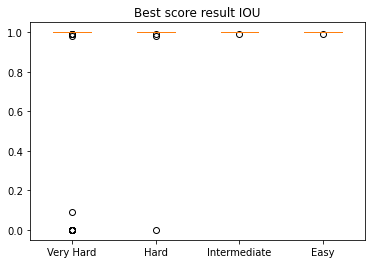

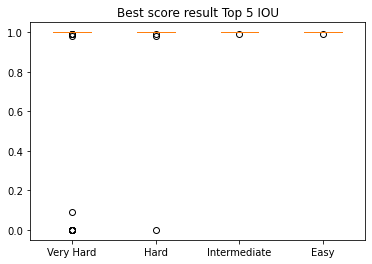

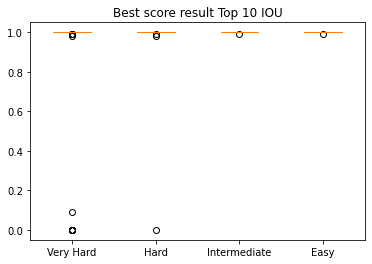

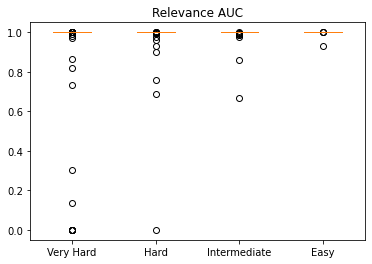

,Top1 IOU,Top 5 IOU,Top 10 IOU,AUC,Top1 IOU > 0,Top 5 IOU > 0,Top 10 IOU > 0,AUC > 0
Very Hard,0.890303,0.910303,0.910303,0.917949,0.989226,0.989460,0.989460,0.976541
Hard,0.989704,0.989704,0.989704,0.981970,0.999701,0.999701,0.999701,0.991889
Intermediate,0.999900,0.999900,0.999900,0.994629,0.999900,0.999900,0.999900,0.994629
Easy,0.999901,0.999901,0.999901,0.999290,0.999901,0.999901,0.999901,0.999290


In [38]:
show_result(simple_examples_result)

## Complex cases

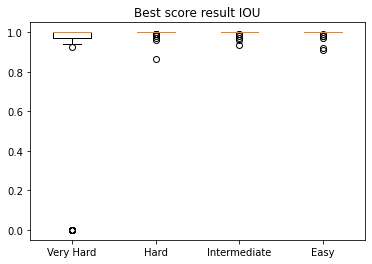

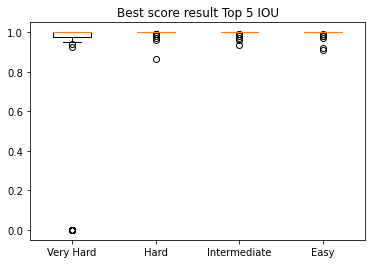

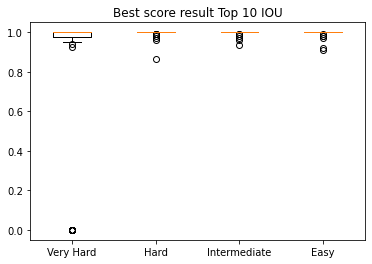

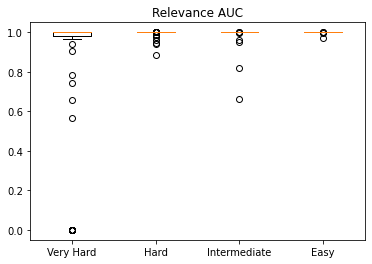

,Top1 IOU,Top 5 IOU,Top 10 IOU,AUC,Top1 IOU > 0,Top 5 IOU > 0,Top 10 IOU > 0,AUC > 0
Very Hard,0.805611,0.815611,0.815611,0.815033,0.994582,0.994648,0.994648,0.981967
Hard,0.997240,0.997240,0.997339,0.996826,0.997240,0.997240,0.997339,0.996826
Intermediate,0.998246,0.998246,0.998246,0.993956,0.998246,0.998246,0.998246,0.993956
Easy,0.997509,0.997509,0.997509,0.999678,0.997509,0.997509,0.997509,0.999678


In [26]:
show_result(complex_examples_result)

## Complex cases 500 size

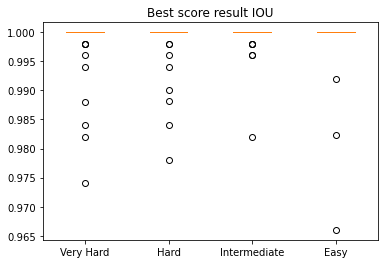

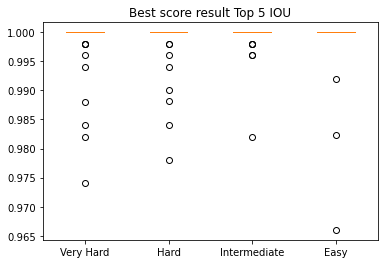

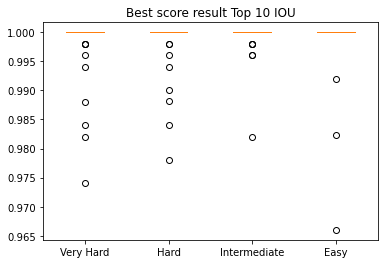

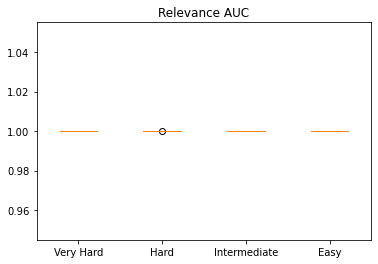

,Top1 IOU,Top 5 IOU,Top 10 IOU,AUC,Top1 IOU > 0,Top 5 IOU > 0,Top 10 IOU > 0,AUC > 0
Very Hard,0.999120,0.999120,0.999120,1.0,0.999120,0.999120,0.999120,1.0
Hard,0.999263,0.999263,0.999263,1.0,0.999263,0.999263,0.999263,1.0
Intermediate,0.999680,0.999680,0.999680,1.0,0.999680,0.999680,0.999680,1.0
Easy,0.999403,0.999403,0.999403,1.0,0.999403,0.999403,0.999403,1.0


In [45]:
show_result(complex_examples_500_result)